In [2]:
#importing necessary libraries
import pandas as pd
import glob
import os
import datetime
import pprint
pp = pprint.PrettyPrinter(indent=4)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.pyplot import figure
import numpy as np
from matplotlib.pyplot import cm

import seaborn as sns

# plt.rcParams.update({'font.family':'monospace'})
import matplotlib
%pip install matplotlib==3.4


# Just write the name of the font
matplotlib.rcParams['font.sans-serif'] = 'Tahoma'
matplotlib.style.use('seaborn-whitegrid') 

# print(matplotlib.rcParams['font.sans-serif'])

Note: you may need to restart the kernel to use updated packages.


In [3]:
#selecting sensorFolder (filled with csv files)
sensorFolder = 'spl-deploy-rc3flr'

In [4]:
#checking content of folder -- this notebook is in the same directory
"""
optional
"""
files = os.listdir('./'+sensorFolder)
# pp.pprint(files)

In [5]:
#selecting all the csv files
files = os.path.join(sensorFolder,"2022*.csv")

# list of merged files returned
files = glob.glob(files)

#sorting files by date
files.sort()
# pp.pprint(files)

#checking a single file
print(files[0])

spl-deploy-rc3flr/2022-05-18.csv


In [6]:
#moving csv data into pandas dataframe
print("Resultant CSV after joining all CSV files at a particular location...");
# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
print(df.head())

Resultant CSV after joining all CSV files at a particular location...
   Unnamed: 0   laeq   lceq   lzeq          time
0           0  64.35  72.85  73.29  1.652933e+09
1           1  64.44  73.43  73.85  1.652933e+09
2           2  64.08  72.59  73.08  1.652933e+09
3           3  64.06  71.71  72.36  1.652933e+09
4           4  63.41  71.62  72.22  1.652933e+09


In [7]:
#adding some helpful columns to the dataframe

#converting epoch time to datetime
df['time'] = df.time.apply(datetime.datetime.fromtimestamp)
df.rename(columns={'time': 'datetime'}, inplace=True)

#extracting exact date
df['date'] = df['datetime'].dt.date

#extracting day of week
df['dayofweek'] = df['datetime'].dt.dayofweek
# df['dayofweek_name'] = df['datetime'].dt.day_name

#extracting extra data
df['time'] = df['datetime'].dt.time
df['hour'] = df['datetime'].dt.hour

# df['min'] = df['datetime'].dt.minute
# df['sec'] = df['datetime'].dt.second

df.head(5)

,Unnamed: 0,laeq,lceq,lzeq,datetime,date,dayofweek,time,hour
0,0,64.35,72.85,73.29,2022-05-18 23:59:16.155,2022-05-18,2,23:59:16.155000,23
1,1,64.44,73.43,73.85,2022-05-18 23:59:16.898,2022-05-18,2,23:59:16.898000,23
2,2,64.08,72.59,73.08,2022-05-18 23:59:18.392,2022-05-18,2,23:59:18.392000,23
3,3,64.06,71.71,72.36,2022-05-18 23:59:19.126,2022-05-18,2,23:59:19.126000,23
4,4,63.41,71.62,72.22,2022-05-18 23:59:19.871,2022-05-18,2,23:59:19.871000,23


In [8]:
#checking data frequency
df.groupby(df.datetime.apply(lambda x: x.timestamp()).astype(int)).laeq.count().value_counts()

1    1297109
2     316918
3          6
Name: laeq, dtype: int64

## Analyzation

In [9]:
#helper functions
def L50(x): 
    return x.quantile(0.5)
def L10(x): 
    return x.quantile(0.1)
def L90(x): 
    return x.quantile(0.9)
def Leq(dbs):
    p2 = 10 ** (np.asarray(dbs) / 10)
    return 10 * np.log10(p2.mean())

In [10]:
TS = df.copy()
group_30m = pd.Grouper(key ='datetime', freq = '30min')
TS_30m = TS.groupby(group_30m).agg({'laeq':[Leq, L10, L50, L90]})
TS_30m.columns = ['Leq', 'L50', 'L10', 'L90']
TS_30m = TS_30m.reset_index()
TS_30m['date'] = TS_30m.datetime.dt.date

group_24hr = pd.Grouper(key ='datetime', freq = '24H')
TS_24hr = TS.groupby(group_24hr).agg({'laeq':[L10]})
TS_24hr.columns = ['ambient24H']


TS_30m['ambient24H'] = TS_30m['datetime'].map(TS_24hr['ambient24H'])

TS_30m.head()


<ipython-input-9-577d79799a93>:10: RuntimeWarning: Mean of empty slice.
  return 10 * np.log10(p2.mean())
/Users/anniechu/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,datetime,Leq,L50,L10,L90,date,ambient24H
0,2022-05-18 15:30:00,67.158434,65.06,65.735,67.177,2022-05-18,NaN
1,2022-05-18 16:00:00,66.213941,65.37,65.920,66.890,2022-05-18,NaN
2,2022-05-18 16:30:00,66.847721,65.44,66.080,67.620,2022-05-18,NaN
3,2022-05-18 17:00:00,66.129460,65.26,65.800,66.670,2022-05-18,NaN
4,2022-05-18 17:30:00,67.659750,65.50,66.080,68.140,2022-05-18,NaN


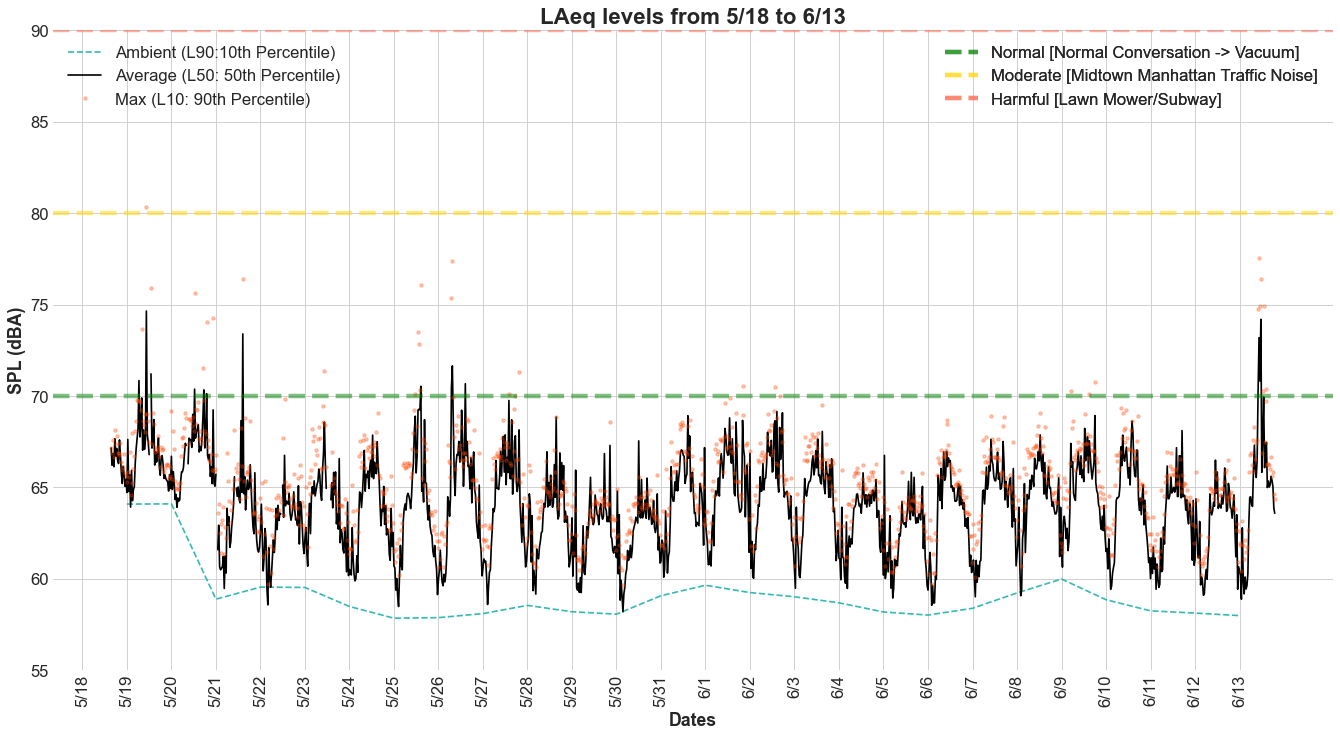

In [45]:
"""
Plotting time-series of entire deployment duration
"""
fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_axes([1, 1, 1, 1])
lw = 4

xdates = TS_30m.datetime
s1mask = np.isfinite(TS_30m.ambient24H)
ambient = TS_30m.ambient24H[s1mask]
avg = TS_30m.Leq
maxs = TS_30m.L90

xlabels = ['/'.join([str(y.month), str(y.day)]) for y in np.unique(xdates.dt.date)]

AmbientL90, = plt.plot(xdates[s1mask], ambient,'--', c='lightseagreen',label = 'Ambient (L90:10th Percentile)', alpha=0.9)
MeanL50, = plt.plot(xdates, avg, '-', c='black',label='Average (L50: 50th Percentile)')
MaxL10,= plt.plot(xdates, maxs,'.',c='orangered',label = 'Max (L10: 90th Percentile)', alpha=0.3)

ref6070 = plt.axhline(70,color='green',linestyle='--',alpha=0.5,linewidth=lw,label='Normal [Normal Conversation -> Vacuum]')
ref7080 = plt.axhline(80,color='gold',linestyle='--',alpha=0.5, linewidth=lw,label='Moderate [Midtown Manhattan Traffic Noise]')
ref8090 = plt.axhline(90,color='tomato',linestyle='--',alpha=0.5,linewidth=lw, label='Harmful [Lawn Mower/Subway]')

# plt.xticks(DTdays_labelDay)  # Set text labels.
plt.xticks(ticks=np.unique(xdates.dt.date),labels=xlabels, fontsize=15, rotation=90) # Set text labels.
plt.yticks(fontsize=15, rotation=0) # Set text labels.

plt.xlabel('Dates', fontsize=16, fontweight='bold')
plt.ylabel('SPL (dBA)', fontsize=16,fontweight='bold')
plt.ylim([55,90])
plt.title(f'LAeq levels from {xlabels[0]} to {xlabels[-1]}', fontsize=20, fontweight='bold')
plt.grid(True)

first_legend = plt.legend(handles=[AmbientL90, MeanL50, MaxL10],facecolor = 'white',loc='upper left', fontsize=15)
plt.gca().add_artist(first_legend)
refLegend= plt.legend(handles=[ref6070, ref7080, ref8090],facecolor = 'white',loc='upper right', fontsize=15)
plt.gca().add_artist(refLegend)

# labelLines(plt.gca().get_lines(), zorder=2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('plotimg/plot.png', bbox_inches='tight')
plt.show()

In [12]:
daysofweekDict = {0:'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                  4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
hrs24 = [str(hr) for hr in np.arange(24)]
hrs12 = {hr: datetime.datetime.strptime(hr, "%H").strftime("%I %p") for hr in hrs24}
# d = datetime.strptime("13", "%H").strftime("%I %p")
print(hrs12)

{'0': '12 AM', '1': '01 AM', '2': '02 AM', '3': '03 AM', '4': '04 AM', '5': '05 AM', '6': '06 AM', '7': '07 AM', '8': '08 AM', '9': '09 AM', '10': '10 AM', '11': '11 AM', '12': '12 PM', '13': '01 PM', '14': '02 PM', '15': '03 PM', '16': '04 PM', '17': '05 PM', '18': '06 PM', '19': '07 PM', '20': '08 PM', '21': '09 PM', '22': '10 PM', '23': '11 PM'}


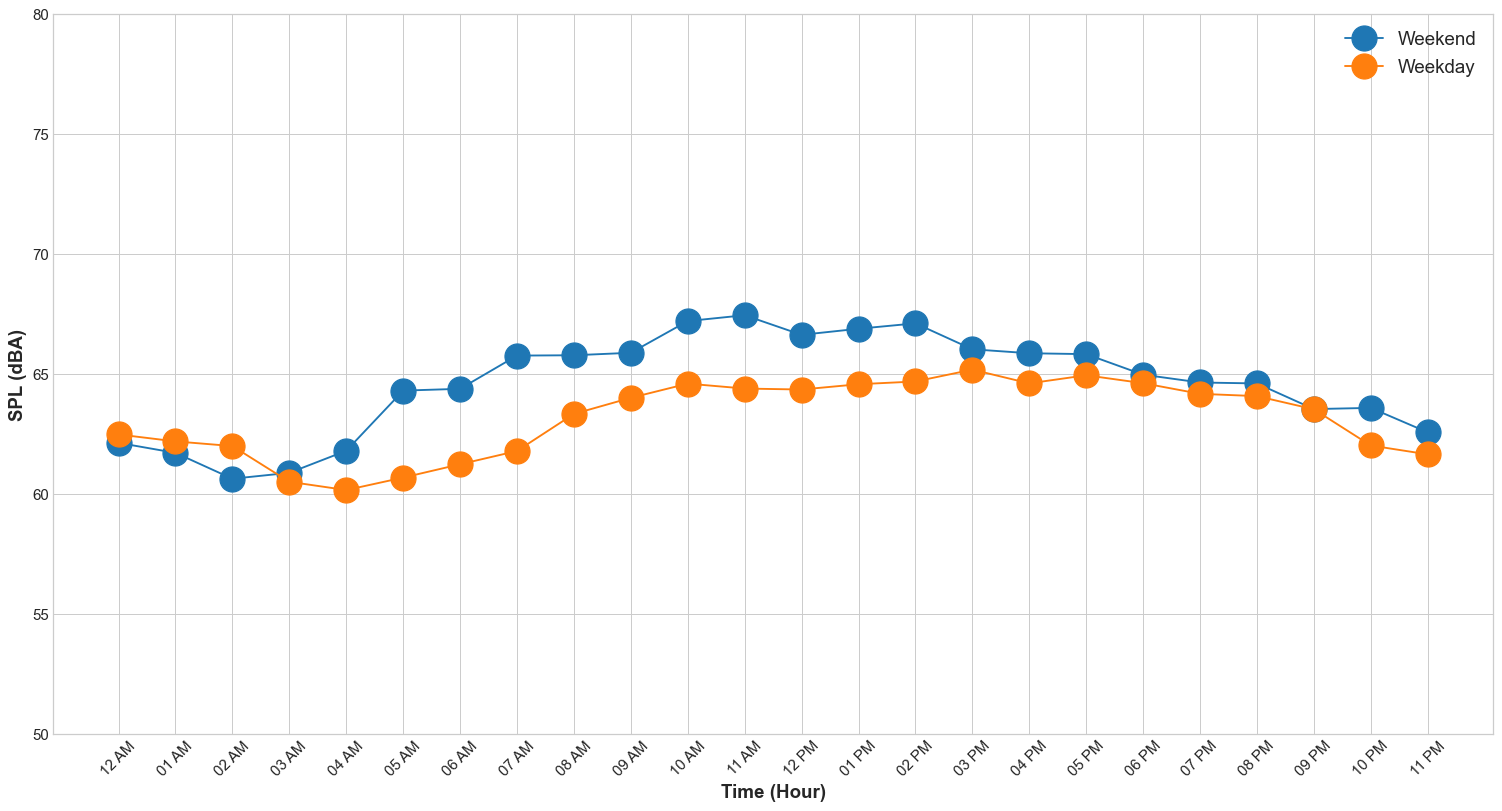

In [23]:
wkdataSPLIT = df.copy()

wkdataSPLIT['isWeekend']= np.where(wkdataSPLIT.dayofweek >=5, True, False)
# wkdataSPLIT.head(-3)
wkDAYS = wkdataSPLIT[wkdataSPLIT['isWeekend'] == True]
wkENDS = wkdataSPLIT[wkdataSPLIT['isWeekend'] == False]
wkDAYS.head(3)

eq_wkDAYS = wkDAYS.groupby(['hour']).agg({'laeq':[Leq]}) #need to replace with leq
eq_wkDAYS.columns= eq_wkDAYS.columns.droplevel(0)

eq_wkENDS = wkENDS.groupby(['hour']).agg({'laeq':[Leq]}) #need to replace with leg
eq_wkENDS.columns= eq_wkENDS.columns.droplevel(0)

eq_wkDAYS.head()


eqWK = eq_wkDAYS.copy()
eqWK = eqWK.rename(columns={'Leq': "wkday"})
eqWK['wkend'] = eq_wkENDS
eqWK


hr_labels = [hrs12[str(hr24)] for hr24 in eqWK.index]

fig2 = figure(figsize=(16, 8), dpi=90)
ax2 = fig2.add_axes([1, 1, 1, 1])
ax2.plot(hr_labels,eqWK.wkend, 'o-', label='Weekend', markersize=20)
ax2.plot(hr_labels, eqWK.wkday,  'o-', label='Weekday', markersize=20)
plt.ylim([50, 80])
plt.yticks(fontsize=12)
plt.xticks(rotation=45, fontsize=12)
ax2.set_xlabel('Time (Hour)', fontsize=15, fontweight='bold')
ax2.set_ylabel('SPL (dBA)', fontsize=15, fontweight='bold')
ax2.legend(facecolor='white', fontsize=15)
ax2.grid(True)
# fig2.show(False)
fig2.savefig("test.png", format="png") # specify filetype explicitly

In [ ]:
daysTS = df.copy()
daysTSagg = daysTS.groupby(['dayofweek']).agg({'laeq':[L10,Leq,L90]}) #need to replace with leq
daysTSagg.columns = daysTSagg.columns.droplevel(0)

xlabelBar = [daysofweekDict[day] for day in daysTSagg.index]
axBar = daysTSagg.plot.bar(figsize=(15,8),rot=0)
axBar.legend(facecolor='white', loc='upper right')
axBar.set_ylim([40, 80])
axBar.set_xlabel('Day of the Week', fontsize=15, fontweight='bold')
axBar.set_ylabel('SPL (dBA)', fontsize=15, fontweight='bold')
axBar.set_xticklabels(xlabelBar,rotation=30, fontsize=12);
for container in axBar.containers:
    axBar.bar_label(container)

In [ ]:
hmAll = df.copy()
hmAll.head()
group_1H = pd.Grouper(key ='datetime', freq = '1H')
hmAll = hmAll.groupby([group_1H]).agg({'laeq':[Leq]})
hmAll.columns = hmAll.columns.droplevel(0)
hmAll['dayofweek'] = hmAll.index.dayofweek
hmAll['hour'] = hmAll.index.hour
hmAll.head()

df3 = hmAll.reset_index().pivot_table(columns='dayofweek',index = 'hour',values='Leq')

# df3.index

fig, ax = plt.subplots(figsize=(18, 10))
hm = sns.heatmap(df3.T, annot = True,vmin = 55, vmax = 70, linewidths=.75,cmap='YlOrRd', cbar_kws={'label': 'dB'});

hm.set_yticklabels([daysofweekDict.get(i) for i in df3.columns])
hm.set_xticklabels([hrs12.get(str(i)) for i in df3.index])

# hm.set_yticks(np.arange(len(timeofdayDict.values()))+0.5)
plt.setp(hm.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.setp(hm.get_xticklabels(), rotation=45, horizontalalignment='center')

plt.ylabel('Day of Week', fontweight='bold')
plt.xlabel('Hour', fontweight='bold')
plt.title(f'Aggregate Heat Map of LAeq 50th Percentile Levels', fontweight='bold');

### Weekly Plots

In [ ]:
"""
|| FUNCTION: backfill a week with empty values if a week starts mid-week
"""
def backfillWeek(df, freq):
    firstDate= np.unique(df.index.date)[0]
    firstDatetime=df.index[0]
    last_monday = firstDate - datetime.timedelta(days=firstDate.weekday())
    print(f'First Date: {firstDate} -> Monday of that Week: {last_monday}')

    #filling in data
    rng = pd.date_range(start=last_monday, end=firstDatetime, closed='left',freq=freq)
#     print(rng)
    return rng

"""
|| FUNCTION: Separate data into weeks (Mon-Sun)
"""
def groupWeek(data, showData = False):
    weeks = {}
    wk = pd.DataFrame(columns = data.columns)
    dates = data.index
    c = 0
#     print(type(wk), type(data))

    for d in dates:
        if (d.dayofweek == 6 and d.time() == dates.time.max()):
            c+=1
            wk.loc[d]=data.loc[d]
            weeks[c] = wk

            wk = pd.DataFrame(columns = data.columns)
        else:
            wk.loc[d]=data.loc[d]
    if showData == True:
        for key in weeks:
            print("\n" +"="*40)
            print(key)
            print("-"*40)
            print(weeks[key])
    return weeks

"""
|| FUNCTION: to plot weekly heatmaps 
"""
def plotHeatMap(datadict, column, index, values, diff=False,labelDoW=False, **kwargs):
    fig1 = plt.figure(figsize=(20, 10))

    averageDF = kwargs.get('refdf', None)
    fig1.subplots_adjust(top=0.9,hspace = .3, wspace=.15)

#     fig1.suptitle('Weekly Heat Map of LAeq 50th Percentile Levels', weight='normal', fontsize=20)

    ncols = 2
    nrows = len(datadict) // ncols + (len(datadict) % ncols > 0)

    for n,wk in enumerate(datadict):
        wkData = datadict[wk]
        dateLabels = np.unique(wkData.index.date)
                
        df3 = wkData.reset_index().pivot(columns=column,index = index,values=values)
        df3.index = df3.index.astype(int)
        
        ax = fig1.add_subplot(ncols,nrows, n+1)
        ax.set_title(f'Week {n+1}: \n{dateLabels[0]} to {dateLabels[-1]}', fontweight='bold')
        if diff == True:
            dfx = df3-averageDF
            vmin = -4
            vmax = 4
            cmap='vlag'
        else:
            dfx = df3
            vmin = 55
            vmax = 70
            cmap='YlOrRd'
            
        ax = sns.heatmap(dfx.T, vmin = vmin, vmax = vmax, linewidths=.5,cmap=cmap, cbar_kws={'label': 'dB'});
        
                
        ax.set_yticklabels([daysofweekDict.get(i) for i in dfx.columns])

        if labelDoW == True:
            ax.set_xticks(np.arange(len(timeofdayDict.values()))+0.5)
            ax.set_xticklabels(timeofdayDict.values(), rotation=0)
        plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

        plt.xlabel('Hour', weight='bold')
        plt.ylabel('Day of Week', weight='bold')


In [ ]:
hmWK = hmAll.copy()

hmWKsplit = groupWeek(hmWK)
wk1 = backfillWeek(hmWKsplit[1], '1H')

hmWKsplit[1] = hmWKsplit[1].append(pd.DataFrame(index=wk1))
hmWKsplit[1] = hmWKsplit[1].sort_index()
hmWKsplit[1]['dayofweek'] = hmWKsplit[1].index.dayofweek
hmWKsplit[1]['hour'] = hmWKsplit[1].index.hour

print(hmWKsplit[1])

In [ ]:
plotHeatMap(hmWKsplit, 'dayofweek', 'hour', 'Leq')

In [ ]:
hmRef = hmAll.copy()

hmRef = hmRef.reset_index().pivot_table(columns='dayofweek',index = 'hour',values='Leq')

plotHeatMap(hmWKsplit,'dayofweek', 'hour', 'Leq', diff=True, refdf = hmRef)

In [ ]:
tts = df.copy()
# histo = tts.hist('laeq', by='dayofweek')
histo = tts.hist('laeq', by='dayofweek', bins=25, range=(50, 80),grid=False, figsize=(12,15), layout=(7,1),sharex=True,color='#FFCF56', zorder=2, rwidth=0.9)

for i,x in enumerate(histo):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("SPL (dB)", labelpad=20, weight='bold', size=15)
    x.set_yticks([])
    x.set_title(daysofweekDict[i], fontweight='bold')

    # Set y-axis label
#     if i == 1:
#         x.set_ylabel("Sessions", labelpad=50, weight='bold', size=12)

    # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=0)
    
# plt.subplots_adjust(hspace=0.05) 


In [ ]:
FFdf = df.copy()

In [ ]:
FFdf.head(4)

In [ ]:
#loudest/quietest day of the week

DTaggs = FFdf.groupby(['dayofweek']).agg({'laeq':[Leq,L50,L10,L90]})
DTaggs.columns = ['Leq','L50', 'L10', 'L90']
DTaggs = DTaggs.reset_index()

mean_min = DTaggs.Leq.min()

mean_minDay = DTaggs.loc[DTaggs['Leq'].idxmin(), 'dayofweek']
print("Minimum Average SPL", mean_min, "dB(A) and its corresponding date:", mean_minDay)

mean_max = DTaggs.Leq.max()
mean_maxDay = DTaggs.loc[DTaggs['Leq'].idxmax(), 'dayofweek']

print("Maximum Average SPL", mean_max, "dB(A) and its corresponding date:", mean_maxDay)

In [ ]:
#d/n split

In [ ]:
dnDF = df.copy()
dnDF.head(5)

dnDF['isWeekend']= np.where(dnDF.dayofweek>=5, True, False)
# wkdataSPLIT.head(-3)
wkDAYS = dnDF[dnDF['isWeekend'] == False]
wkENDS = dnDF[dnDF['isWeekend'] == True]
wkDAYS.head(10)
# wkENDS.head(10)

wkDAYS['isDay']= np.where((wkDAYS.time > datetime.time(6,0)) & (wkDAYS.time < datetime.time(18,0)), True, False)
DAY_wkDAYS = wkDAYS[wkDAYS['isDay'] == True]
NIGHT_wkDAYS = wkDAYS[wkDAYS['isDay'] == False]


wkENDS['isDay']= np.where((wkENDS.time > datetime.time(6,0)) & (wkENDS.time < datetime.time(18,0)), True, False)
DAY_wkENDS = wkENDS[wkENDS['isDay'] == True]
NIGHT_wkENDS = wkENDS[wkENDS['isDay'] == False]

NIGHT_wkENDS.sort_values(by=['datetime']).head()

In [ ]:
#find ambient levels per day/night weekday/weekend

def aggit(df, metric):
    agg = df.groupby(['date']).agg({'laeq':[metric]})
    agg.columns = [str(metric)]
    agg = agg.reset_index()
#     print(str(df))
    return Leq(agg[str(metric)])

dnwk = [DAY_wkDAYS, NIGHT_wkDAYS, DAY_wkENDS, NIGHT_wkENDS]
dnwk_labels = ['WeekdayDay', 'WeekdayNight', 'WeekendDay', 'WeekendNight']
dnwk_full = dict.fromkeys(dnwk_labels)
dnwk_AMBIENT = [aggit(df, L10) for df in dnwk]
dnwk_LEQ = [aggit(df, Leq) for df in dnwk]

dnwkinfo = list(zip(dnwk_AMBIENT, dnwk_LEQ))
dnwk_full = dict(zip(dnwk_labels, dnwkinfo))
dnwk_full

In [ ]:
vals = list(dnwk_full.values())
vals_am=list(zip(*vals))[0]
vals_avg = list(zip(*vals))[1]
keys = list(dnwk_full.keys())
# max_val
print(keys[vals_am.index(max(vals_am))], max(vals_am))
print(keys[vals_avg.index(max(vals_avg))], max(vals_avg))